<a href="https://colab.research.google.com/github/H93JEBALI/Stock-Crypto-prediction/blob/main/Price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import pandas as pd

# Load data
df_b = pd.read_csv('bitstampUSD.csv')
df_b.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-04-23,234.052994,236.475006,233.199005,236.462006,236.462006,17036000.0
1,2015-04-24,235.970001,236.304993,229.932999,231.268005,231.268005,21448700.0
2,2015-04-25,231.235001,232.561005,226.337006,226.389999,226.389999,13957200.0
3,2015-04-26,226.410004,226.944000,214.873993,219.429993,219.429993,28943700.0
4,2015-04-27,219.429001,233.304993,218.022995,229.285995,229.285995,38574000.0


In [ ]:
df_b[df_b['Close'] == max(df_b['Close'])][['Date', 'Close']]

In [31]:
# Load data
df_c = pd.read_csv('coinbaseUSD.csv')
df_c.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1417411980,300.0,300.0,300.0,300.0,0.01,3.0,300.0
1,1417412040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1417412100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1417412160,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1417412220,NaN,NaN,NaN,NaN,NaN,NaN,NaN


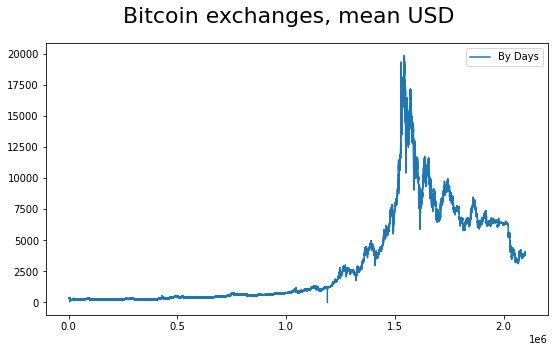

In [33]:
import matplotlib.pyplot as plt

# PLOTS
fig = plt.figure(figsize=[9, 5])
plt.suptitle('Bitcoin exchanges, mean USD', fontsize=22)

plt.plot(df_c.Weighted_Price, '-', label='By Days')
plt.legend()

# plt.tight_layout()
plt.show()

In [34]:
df_c['date'] = pd.to_datetime(df_c['Timestamp'],unit='s').dt.date
group = df_c.groupby('date')
Real_Price = group['Weighted_Price'].mean()

In [47]:
# split data
prediction_days = 200
df_train= Real_Price[len(Real_Price)-prediction_days:]
df_test= Real_Price[:len(Real_Price)-prediction_days]

In [48]:
import numpy as np

# Data preprocess
training_set = df_train.values
training_set = np.reshape(training_set, (len(training_set), 1))
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
training_set = sc.fit_transform(training_set)
X_train = training_set[0:len(training_set)-1]
y_train = training_set[1:len(training_set)]
X_train = np.reshape(X_train, (len(X_train), 1, 1))

In [49]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# Initialising the RNN
regressor = Sequential()

# Adding the input layer and the LSTM layer
regressor.add(LSTM(units = 4, activation = 'sigmoid', input_shape = (None, 1)))

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, batch_size = 5, epochs = 100)

Epoch 1/100
40/40 [==============================] - 1s 2ms/step - loss: 0.0740
Epoch 2/100
40/40 [==============================] - 0s 2ms/step - loss: 0.0584
Epoch 3/100
40/40 [==============================] - 0s 2ms/step - loss: 0.0538
Epoch 4/100
40/40 [==============================] - 0s 2ms/step - loss: 0.0520
Epoch 5/100
40/40 [==============================] - 0s 2ms/step - loss: 0.0506
Epoch 6/100
40/40 [==============================] - 0s 2ms/step - loss: 0.0491
Epoch 7/100
40/40 [==============================] - 0s 2ms/step - loss: 0.0474
Epoch 8/100
40/40 [==============================] - 0s 2ms/step - loss: 0.0459
Epoch 9/100
40/40 [==============================] - 0s 2ms/step - loss: 0.0443
Epoch 10/100
40/40 [==============================] - 0s 2ms/step - loss: 0.0429
Epoch 11/100
40/40 [==============================] - 0s 2ms/step - loss: 0.0411
Epoch 12/100
40/40 [==============================] - 0s 2ms/step - loss: 0.0397
Epoch 13/100
40/40 [=================

In [50]:
test_set = df_test.values[1:]
sc = MinMaxScaler()
inputs = np.reshape(df_test.values[0:len(df_test)-1], (len(test_set), 1))
inputs = sc.fit_transform(inputs)
inputs = np.reshape(inputs, (len(inputs), 1, 1))
predicted_BTC_price = regressor.predict(inputs)
predicted_BTC_price = sc.inverse_transform(predicted_BTC_price)

In [53]:
df_test.values[1:]

array([[datetime.date(2014, 12, 2), 377.8549107142857],
       [datetime.date(2014, 12, 3), 377.8183333333333],
       [datetime.date(2014, 12, 4), 377.1],
       ...,
       [datetime.date(2018, 6, 19), 6717.368488020486],
       [datetime.date(2018, 6, 20), 6679.929394851527],
       [datetime.date(2018, 6, 21), 6733.646003557856]], dtype=object)

In [52]:
predicted_BTC_price

array([[ 343.51987],
       [ 384.67258],
       [ 384.63876],
       ...,
       [6567.679  ],
       [6767.358  ],
       [6728.7524 ]], dtype=float32)

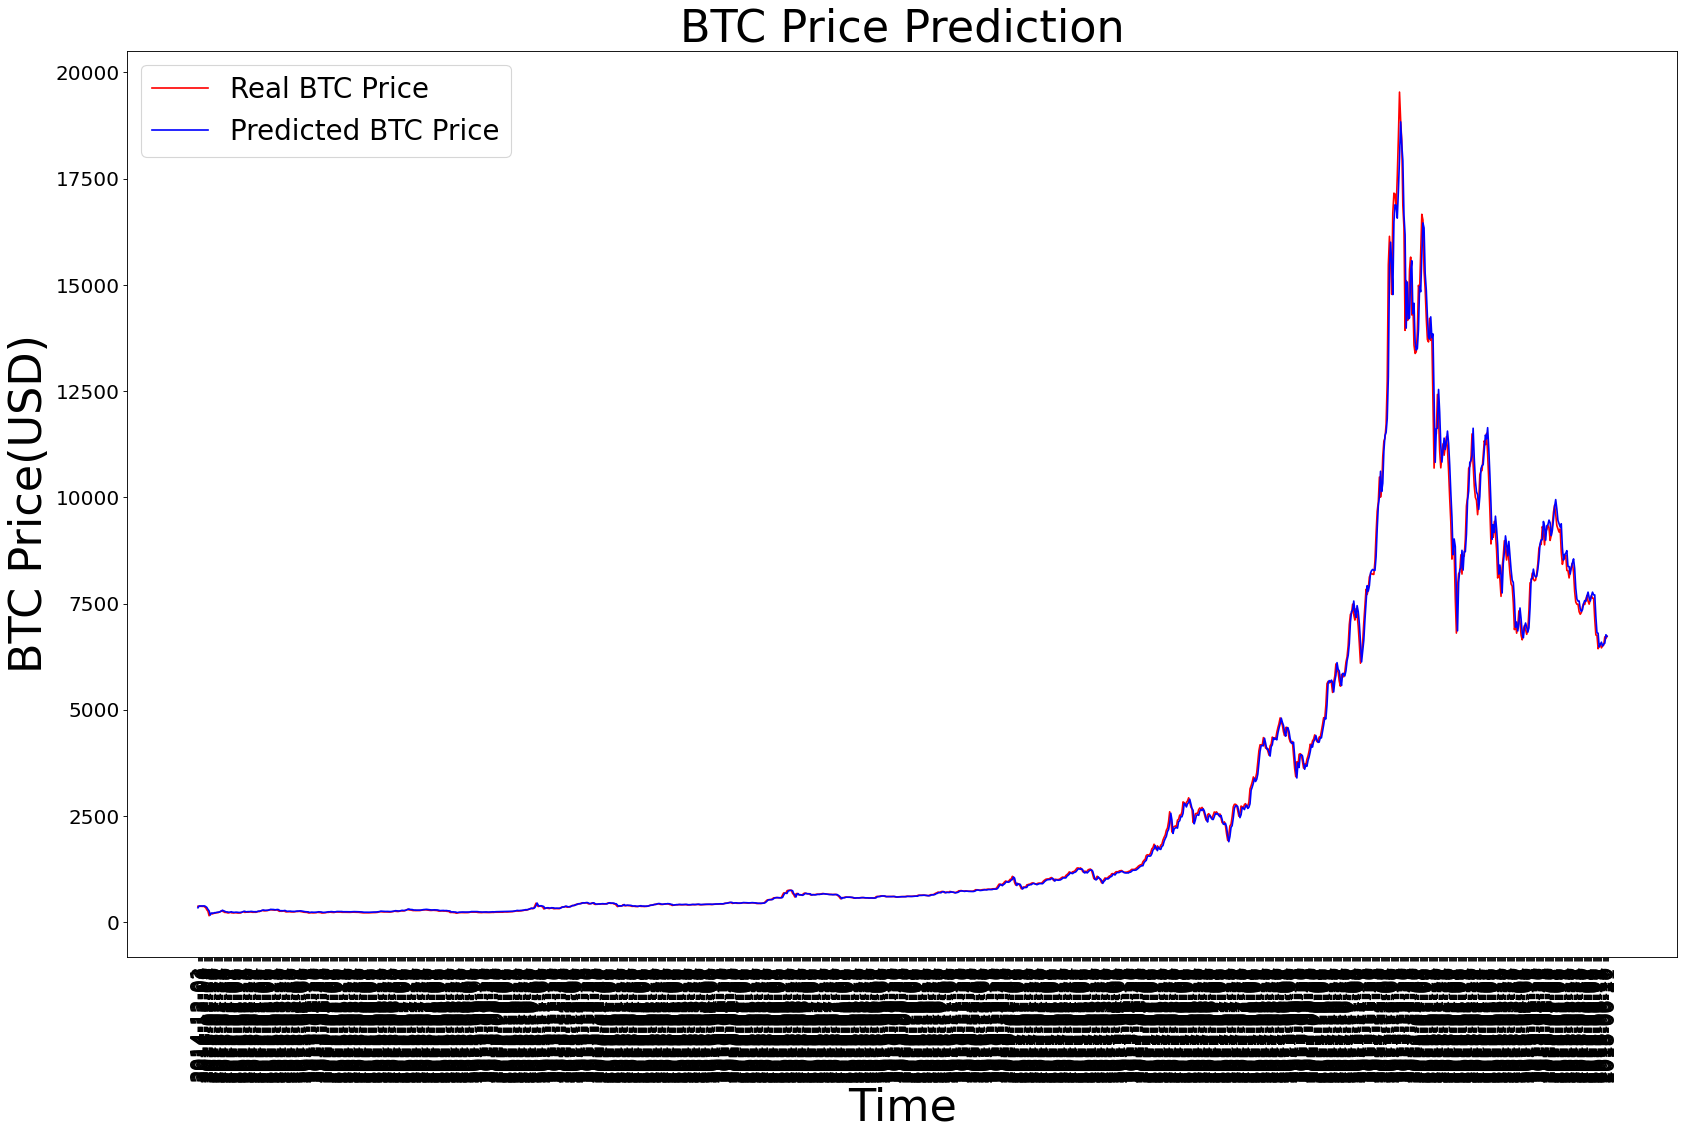

In [51]:
plt.figure(figsize=(25,15), dpi=80, facecolor='w', edgecolor='k')
ax = plt.gca()  
plt.plot(test_set, color = 'red', label = 'Real BTC Price')
plt.plot(predicted_BTC_price, color = 'blue', label = 'Predicted BTC Price')
plt.title('BTC Price Prediction', fontsize=40)
df_test = df_test.reset_index()
x=df_test.index
labels = df_test['date']
plt.xticks(x, labels, rotation = 'vertical')
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(18)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(18)
plt.xlabel('Time', fontsize=40)
plt.ylabel('BTC Price(USD)', fontsize=40)
plt.legend(loc=2, prop={'size': 25})
plt.show()